In [2]:
from roboflow import Roboflow
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import torch
from ultralytics import YOLO

In [3]:
rf = Roboflow(api_key="SEG1TC7dNS2rFtvRdPzc")
project = rf.workspace("dronecv").project("mineguard-thermal")
version = project.version(15)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MineGuard-Thermal-15 in yolov8:: 100%|██████████| 6096/6096 [00:05<00:00, 1187.35it/s]


In [4]:
# --- Global Configuration for the Project ---
# IMPORTANT: Adjust this path to where your Roboflow dataset is located.
# Example for Colab: '/content/MineGuard-Thermal-15' if you downloaded version 15.
DATASET_ROOT = dataset.location

# Path to your data.yaml file, usually inside the DATASET_ROOT.
DATA_YAML_PATH = os.path.join(DATASET_ROOT, 'data.yaml')

# Project and Run names for organizing training results in the 'runs' directory.
PROJECT_NAME = 'mine_detection_thermal'
RUN_NAME = 'yolov8_thermal_mines_t4_run_1' # Increment this for new major training runs (e.g., _v2, _long_epochs)

# YOLOv8 model version to use.
# 'yolov8n.pt' (nano): Fastest, smallest. Good for quick tests.
# 'yolov8s.pt' (small): Great balance of speed and accuracy. Recommended starting point for T4.
# 'yolov8m.pt' (medium): More accurate, but slower and uses more VRAM. T4 can handle this.
YOLO_MODEL_VERSION = 'yolov8m.pt'

# --- Configuration Specific to Visualization ---
# Choose the data split you want to explore ('train', 'valid', or 'test')
VIS_DATA_SPLIT = 'valid' # You can change this to 'train' or 'test'

# Number of random images to display for exploration
NUM_IMAGES_TO_SHOW = 5

In [5]:
print(f"Number of GPUs available: {torch.cuda.device_count()}")

Number of GPUs available: 0


In [6]:
# --- 1. Environment Check (GPU) ---
print("--- Checking GPU Environment ---")
CUDA_AVAILABLE = torch.cuda.is_available()
print(f"CUDA available: {CUDA_AVAILABLE}")

if CUDA_AVAILABLE:
    num_gpus = torch.cuda.device_count()
    if num_gpus > 0:
        print(f"Total GPUs detected: {num_gpus}")
        for i in range(num_gpus):
            print(f"GPU {i} Name: {torch.cuda.get_device_name(i)}")

        if num_gpus > 1:
            # Use all available GPUs for distributed training
            DEVICE_TO_USE = list(range(num_gpus))
            print(f"Configured to use multiple GPUs: {DEVICE_TO_USE}")
        else:
            # Use the single available GPU
            DEVICE_TO_USE = 0
            print(f"Configured to use single GPU: {DEVICE_TO_USE}")
    else:
        print("CUDA available but no GPUs found. This is unusual.")
        DEVICE_TO_USE = 'cpu' # Fallback to CPU
else:
    print("CUDA not available. Training will default to CPU, which will be SIGNIFICANTLY slower.")
    DEVICE_TO_USE = 'cpu' # Use CPU
print("-" * 40)

# --- 2. data.yaml File Check ---
# Essential to confirm your dataset configuration is accessible.
if not os.path.exists(DATA_YAML_PATH):
    print(f"ERROR: data.yaml file not found at: {DATA_YAML_PATH}")
    print("Please ensure DATASET_ROOT is correct and data.yaml is inside it.")
    # Debugging helper: list contents if data.yaml is missing
    if os.path.exists(os.path.dirname(DATASET_ROOT)):
        print(f"Contents of '{os.path.dirname(DATASET_ROOT)}': {os.listdir(os.path.dirname(DATASET_ROOT))}")
    if os.path.exists(DATASET_ROOT):
        print(f"Contents of '{DATASET_ROOT}': {os.listdir(DATASET_ROOT)}")
    # If this is run in a Kaggle notebook, you might prefer to raise an error
    # or just print a warning instead of exiting directly, as exiting stops the kernel.
    # For a robust script, `exit()` is fine. For interactive notebooks, consider `raise FileNotFoundError`.
    raise FileNotFoundError(f"data.yaml not found at {DATA_YAML_PATH}") # More graceful for notebooks
else:
    print(f"data.yaml file found: {DATA_YAML_PATH}")
    print("\nContent of data.yaml:")
    with open(DATA_YAML_PATH, 'r') as f:
        print(f.read())
    print("-" * 40)

--- Checking GPU Environment ---
CUDA available: False
CUDA not available. Training will default to CPU, which will be SIGNIFICANTLY slower.
----------------------------------------
data.yaml file found: c:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\data.yaml

Content of data.yaml:
names:
- landmine
nc: 1
roboflow:
  license: CC BY 4.0
  project: mineguard-thermal
  url: https://universe.roboflow.com/dronecv/mineguard-thermal/dataset/15
  version: 15
  workspace: dronecv
test: ../test/images
train: ../train/images
val: ../valid/images

----------------------------------------


In [7]:
# --- 3. Dataset Visualization Function ---
def explore_yolo_dataset_random(dataset_root_path, data_split, num_images):
    """
    Loads random images and their YOLO annotations from a specified dataset split,
    then displays them with bounding boxes and class names.
    """
    print(f"\n--- Starting Dataset Visualization for '{data_split}' split ---")
    data_yaml_local_path = os.path.join(dataset_root_path, 'data.yaml')
    with open(data_yaml_local_path, 'r') as f:
        data_config = yaml.safe_load(f)

    class_names = data_config['names']
    print(f"Detected classes in dataset: {class_names}")

    images_dir = os.path.join(dataset_root_path, data_split, 'images')
    labels_dir = os.path.join(dataset_root_path, data_split, 'labels')

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"Error: Image or label directories for '{data_split}' not found at '{images_dir}' or '{labels_dir}'.")
        return

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    if not image_files:
        print(f"No images found in '{images_dir}'.")
        return

    # Randomly shuffle and select images
    random.shuffle(image_files)
    selected_image_files = image_files[:num_images]

    print(f"Displaying {len(selected_image_files)} random images from '{data_split}' split...")

    for i, image_filename in enumerate(selected_image_files):
        image_path = os.path.join(images_dir, image_filename)
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_filename)

        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_filename}. Skipping.")
            continue
        img_height, img_width, _ = img.shape

        if not os.path.exists(label_path) or os.path.getsize(label_path) == 0:
            print(f"Info: No annotation file or empty for {image_filename}. Displaying without boxes.")
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Image: {image_filename} (No annotations)")
            plt.axis('off')
            plt.show()
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])
            center_x_norm, center_y_norm, width_norm, height_norm = parts[1:]

            center_x_px = int(center_x_norm * img_width)
            center_y_px = int(center_y_norm * img_height)
            width_px = int(width_norm * img_width)
            height_px = int(height_norm * img_height)

            x1 = int(center_x_px - width_px / 2)
            y1 = int(center_y_px - height_px / 2)
            x2 = int(center_x_px + width_px / 2)
            y2 = int(center_y_px + height_px / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box
            label = class_names[class_id]
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {image_filename} (Split: {data_split})")
        plt.axis('off')
        plt.show()
    print("-" * 40)

# --- 4. YOLOv8 Model Training Function ---
def train_yolov8_thermal_model():
    print(f"\n--- Starting YOLOv8 Model Training with '{YOLO_MODEL_VERSION}' ---")
    model = YOLO(YOLO_MODEL_VERSION) # Load a pre-trained YOLOv8 model

    print(f"Training will use dataset: {DATA_YAML_PATH}")
    print(f"Results will be saved in: runs/detect/{PROJECT_NAME}/{RUN_NAME}")
    print(f"Using device(s): {DEVICE_TO_USE}")

    recommended_batch_size = 14
    if isinstance(DEVICE_TO_USE, list) and len(DEVICE_TO_USE) > 1:
        print(f"Multi-GPU training detected. Setting batch size to {recommended_batch_size} (divided among {len(DEVICE_TO_USE)} GPUs).")
    else:
        recommended_batch_size = 14
        print(f"Single device training detected. Setting batch size to {recommended_batch_size}.")

    results = model.train(
        data=DATA_YAML_PATH, # Path to dataset configuration file
        epochs=50,          # Number of training epochs. Adjust as needed.
        imgsz=640,           # Input image size.
        batch=recommended_batch_size, # Use the dynamically adjusted batch size
        name=RUN_NAME,       # Unique name for this training run's folder
        project=PROJECT_NAME,# Parent project folder for organization
        device=DEVICE_TO_USE,# **This is the key line – it will be [0, 1] for two GPUs**

        # --- Recommended Hyperparameters for T4 Training ---
        optimizer='AdamW',   # Optimizer. AdamW is often a strong choice for YOLOv8.
        lr0=0.001,           # Initial learning rate.
        lrf=0.01,            # Final learning rate (multiplier of lr0).
        weight_decay=0.0005, # L2 regularization to prevent overfitting.

        # --- Early Stopping and Saving Strategy ---
        patience=50,         # Stop training if mAP@0.5:0.95 doesn't improve for 50 epochs.
        save_period=10,      # Save model weights every 10 epochs.
        cache=True,          # Cache images to RAM/VRAM for faster loading (good for T4 with sufficient RAM).
    )


    print("\n--- Training Finished! ---")
    print(f"Detailed results (logs, model weights, metrics, plots) are in:")
    print(f"runs/detect/{PROJECT_NAME}/{RUN_NAME}")
    print(f"The best trained model (best.pt) is typically at: runs/detect/{PROJECT_NAME}/{RUN_NAME}/weights/best.pt")

    # --- 5. Immediate Evaluation on Validation Set ---
    print("\n--- Running Evaluation on the VALIDATION Set ---")
    # For evaluation, you typically don't need to specify multiple devices explicitly
    # as the model will already be loaded and can use the primary GPU.
    metrics = model.val() # Evaluate on the default validation set

    print("\n--- Validation Metrics ---")
    print(f"mAP@0.5 (mAP with IoU threshold of 0.5): {metrics.results_dict['metrics/mAP50(B)']:.4f}")
    print(f"mAP@0.5:0.95 (mAP across various IoU thresholds): {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
    print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
    print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")
    print("-" * 40)


--- Starting Dataset Visualization for 'valid' split ---
Detected classes in dataset: ['landmine']
Displaying 5 random images from 'valid' split...


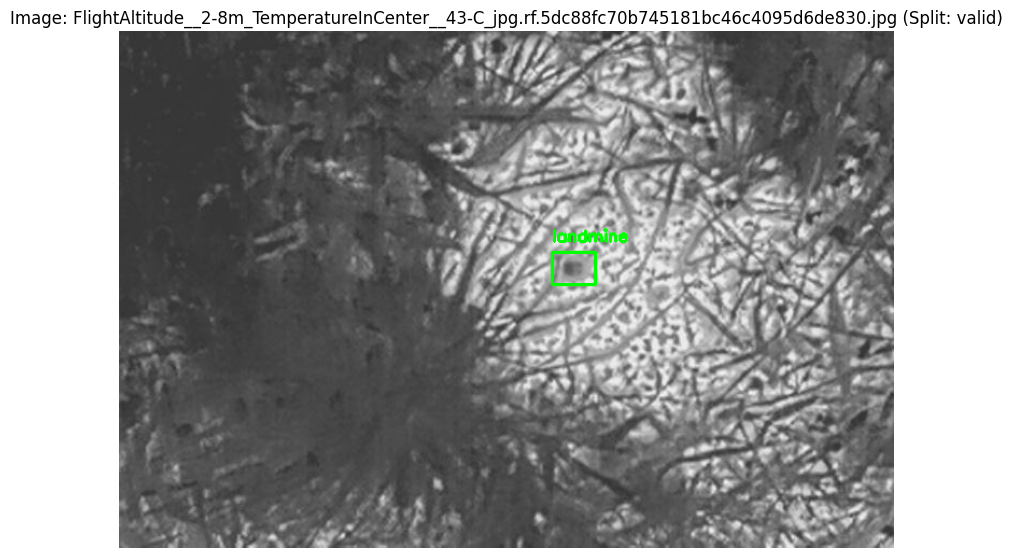

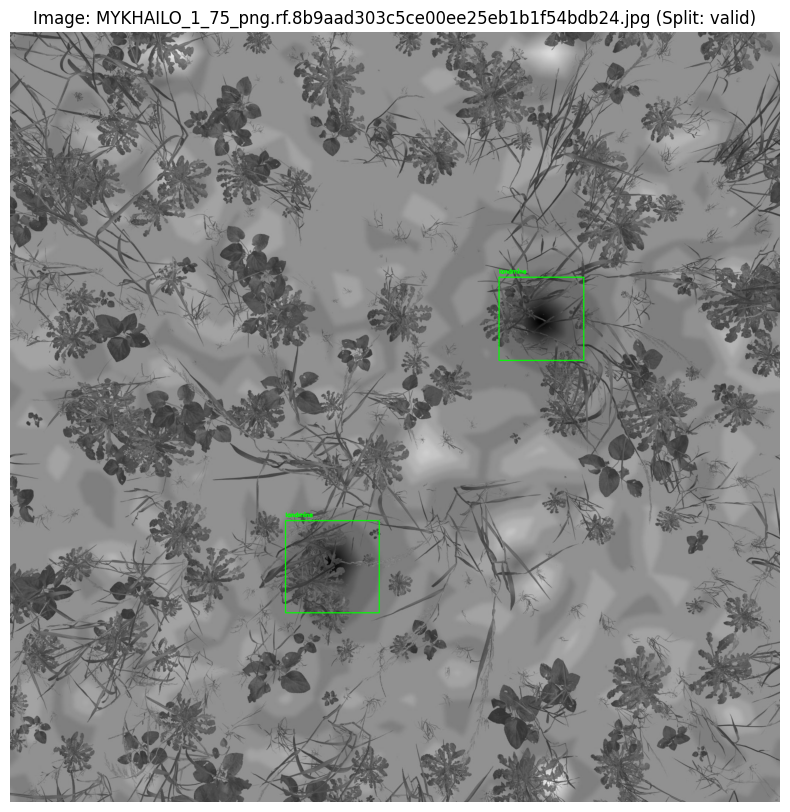

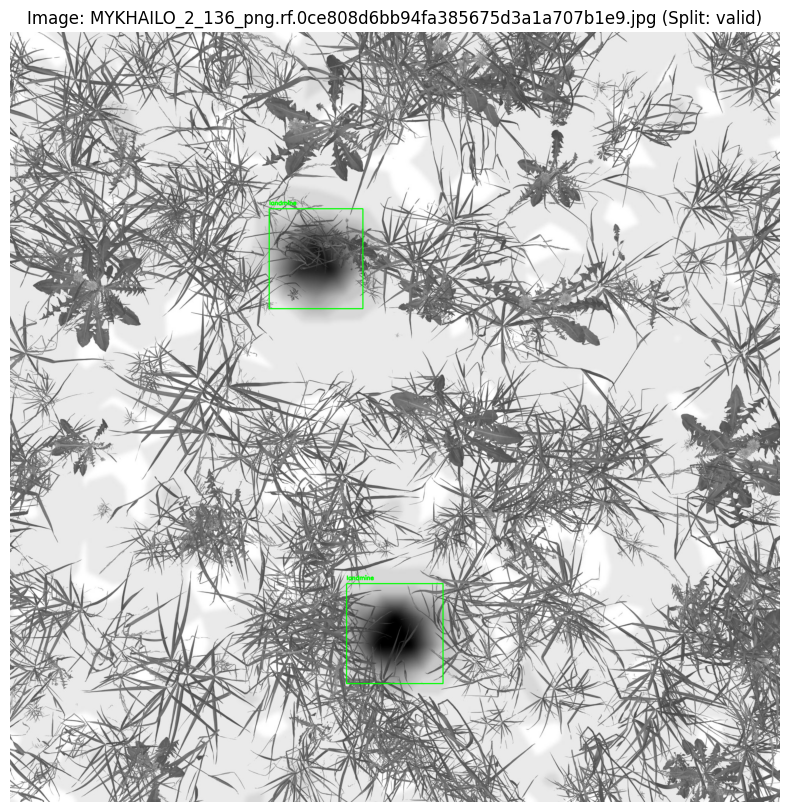

Info: No annotation file or empty for FlightAltitude__1-3m_TemperatureInCenter__34-C_jpg.rf.3bf812d9cade68ee56815ae29ad0dcb6.jpg. Displaying without boxes.


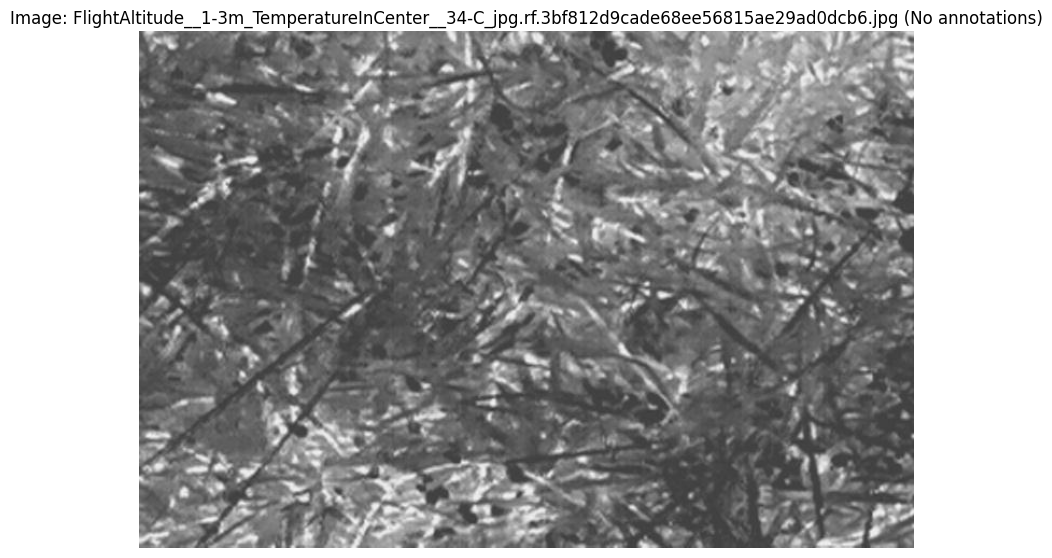

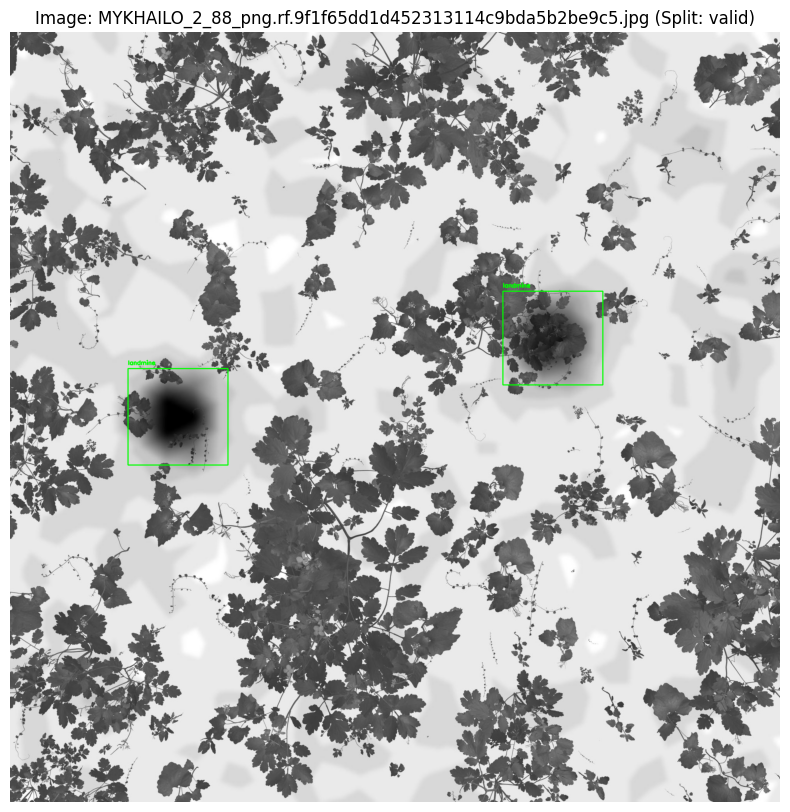

----------------------------------------


In [8]:
explore_yolo_dataset_random(DATASET_ROOT, VIS_DATA_SPLIT, NUM_IMAGES_TO_SHOW)

In [ ]:
# Then, proceed with training the YOLOv8 model
train_yolov8_thermal_model()


--- Starting YOLOv8 Model Training with 'yolov8m.pt' ---


100%|██████████| 49.7M/49.7M [00:07<00:00, 6.72MB/s]


Training will use dataset: c:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\data.yaml
Results will be saved in: runs/detect/mine_detection_thermal/yolov8_thermal_mines_t4_run_1
Using device(s): cpu
Single device training detected. Setting batch size to 14.
Ultralytics 8.3.162  Python-3.10.11 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=14, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras

100%|██████████| 755k/755k [00:10<00:00, 75.8kB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3776275  ultralytics.nn.modules.head.Detect           [1, [192, 384, 576]]          
Model summary: 169 layers, 25,856,899 parameters, 25,856,883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access  (ping: 0.10.0 ms, read: 1248.9725.9 MB/s, size: 331.3 KB)


train: Scanning C:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\train\labels... 2132 images, 93 backgrounds, 0 corrupt: 100%|██████████| 2132/2132 [00:00<00:00, 2801.17it/s]


train: New cache created: C:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\train\labels.cache
WARNING train: 3.3GB RAM required to cache images with 50% safety margin but only 1.6/15.6GB available, not caching images
val: Fast image access  (ping: 0.00.0 ms, read: 2066.41368.1 MB/s, size: 211.6 KB)


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
val: Scanning C:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\valid\labels... 607 images, 27 backgrounds, 0 corrupt: 100%|██████████| 607/607 [00:00<00:00, 2970.39it/s]

val: New cache created: C:\Users\ismae\Workplace\minetrack\notebooks\MineGuard-Thermal-15\valid\labels.cache


WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 607/607 [00:02<00:00, 221.19it/s] 
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.


Plotting labels to mine_detection_thermal\yolov8_thermal_mines_t4_run_1\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.000546875), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to mine_detection_thermal\yolov8_thermal_mines_t4_run_1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.975      2.702      1.648         44        640:   7%|▋         | 10/153 [18:04<4:58:04, 125.07s/it]

In [ ]:
RUN_DIR = os.path.join('runs', PROJECT_NAME, RUN_NAME)

# Construct the full path to the results.csv file
RESULTS_CSV_PATH = os.path.join(RUN_DIR, 'results.csv')

print(f"Attempting to load results from: {RESULTS_CSV_PATH}")

# Check if the file exists before trying to read it
if not os.path.exists(RESULTS_CSV_PATH):
    print(f"Error: The results.csv file was not found at {RESULTS_CSV_PATH}.")
    print("Please verify:")
    print(f"1. That '{RUN_NAME}' is the exact name of your training run folder.")
    print("2. That the training process completed successfully and generated the results files.")
    print(f"3. Check the content of '{RUN_DIR}' to confirm paths:")
    # List contents for debugging
    if os.path.exists(RUN_DIR):
        print(f"Content of '{RUN_DIR}': {os.listdir(RUN_DIR)}")
    elif os.path.exists(os.path.join('runs', PROJECT_NAME)):
        print(f"Content of 'runs/{PROJECT_NAME}': {os.listdir(os.path.join('runs', PROJECT_NAME))}")
    elif os.path.exists('runs/detect'):
        print(f"Content of 'runs/detect': {os.listdir('runs/detect')}")
        if os.path.exists(os.path.join('runs', 'detect', PROJECT_NAME)):
            print(f"Content of 'runs/detect/{PROJECT_NAME}': {os.listdir(os.path.join('runs', 'detect', PROJECT_NAME))}")
    else:
        print("The 'runs' directory or its subdirectories do not exist. Training might not have run or completed.")
else:
    try:
        # Load the CSV file into a pandas DataFrame
        # Ultralytics results.csv files typically have headers.
        df_results = pd.read_csv(RESULTS_CSV_PATH)

        print("\nSuccessfully loaded results.csv! Here are the first 5 rows:")
        print(df_results.head())

        print(f"\nAnd here are the columns available in the DataFrame: {df_results.columns.tolist()}")

        # --- Plotting the Metrics ---

        # 1. Plotting Loss Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss', color='blue')
        plt.plot(df_results['epoch'], df_results['val/box_loss'], label='Validation Box Loss', color='blue', linestyle='--')
        plt.plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Class Loss', color='green')
        plt.plot(df_results['epoch'], df_results['val/cls_loss'], label='Validation Class Loss', color='green', linestyle='--')
        plt.plot(df_results['epoch'], df_results['train/dfl_loss'], label='Train DFL Loss', color='red')
        plt.plot(df_results['epoch'], df_results['val/dfl_loss'], label='Validation DFL Loss', color='red', linestyle='--')
        plt.title('Loss Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. Plotting mAP Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='Validation mAP@0.5', color='purple')
        plt.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='Validation mAP@0.5:0.95', color='orange')
        plt.title('Mean Average Precision (mAP) Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Plotting Precision and Recall Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Validation Precision', color='teal')
        plt.plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Validation Recall', color='magenta')
        plt.title('Precision and Recall Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    except pd.errors.EmptyDataError:
        print(f"Error: The file {RESULTS_CSV_PATH} is empty.")
    except KeyError as e:
        print(f"Error: Missing expected column in results.csv: {e}")
        print("Please check the column names in your results.csv file.")
        # Only try to print columns if df_results was successfully loaded
        if 'df_results' in locals():
            print(f"Available columns: {df_results.columns.tolist()}")
    except Exception as e:
        print(f"An unexpected error occurred while reading or plotting the CSV file: {e}")


In [ ]:
# --- Accessing the results.csv file ---

# Construct the path to the run directory
RUN_DIR = os.path.join(PROJECT_NAME, RUN_NAME)

# Construct the full path to the results.csv file
RESULTS_CSV_PATH = os.path.join(RUN_DIR, 'results.csv')

print(f"Attempting to load results from: {RESULTS_CSV_PATH}")

# Check if the file exists before trying to read it
if not os.path.exists(RESULTS_CSV_PATH):
    print(f"Error: The results.csv file was not found at {RESULTS_CSV_PATH}.")
    print("Please verify:")
    print(f"1. That '{RUN_NAME}' is the exact name of your training run folder.")
    print("2. That the training process completed successfully and generated the results files.")
    print("3. Check the content of the 'runs' directory to confirm paths:")
    # List contents for debugging
    if os.path.exists('runs/detect'):
        print(f"Content of 'runs/detect': {os.listdir('runs/detect')}")
        if os.path.exists(os.path.join('runs', 'detect', PROJECT_NAME)):
            print(f"Content of 'runs/detect/{PROJECT_NAME}': {os.listdir(os.path.join('runs', 'detect', PROJECT_NAME))}")
    else:
        print("The 'runs' directory does not exist. Training might not have run or completed.")
else:
    try:
        # Load the CSV file into a pandas DataFrame
        df_results = pd.read_csv(RESULTS_CSV_PATH)

        print("\nSuccessfully loaded results.csv! Here are the first 5 rows:")
        print(df_results.head())

        print(f"\nAnd here are the columns available in the DataFrame: {df_results.columns.tolist()}")

    except pd.errors.EmptyDataError:
        print(f"Error: The file {RESULTS_CSV_PATH} is empty.")
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")

In [ ]:
print(f"Attempting to load results from: {RESULTS_CSV_PATH}")

# Check if the file exists before trying to read it
if not os.path.exists(RESULTS_CSV_PATH):
    print(f"Error: The results.csv file was not found at {RESULTS_CSV_PATH}.")
    print("Please verify:")
    print(f"1. That '{RUN_NAME}' is the exact name of your training run folder.")
    print("2. That the training process completed successfully and generated the results files.")
    print(f"3. Check the content of '{RUN_DIR}' to confirm paths:")
    # List contents for debugging
    if os.path.exists(RUN_DIR):
        print(f"Content of '{RUN_DIR}': {os.listdir(RUN_DIR)}")
    elif os.path.exists('runs/detect'):
        print(f"Content of 'runs/detect': {os.listdir('runs/detect')}")
        if os.path.exists(os.path.join('runs', 'detect', PROJECT_NAME)):
            print(f"Content of 'runs/detect/{PROJECT_NAME}': {os.listdir(os.path.join('runs', 'detect', PROJECT_NAME))}")
    else:
        print("The 'runs' directory does not exist. Training might not have run or completed.")
else:
    try:
        # Load the CSV file into a pandas DataFrame
        # Ultralytics results.csv files typically have headers.
        df_results = pd.read_csv(RESULTS_CSV_PATH)

        print("\nSuccessfully loaded results.csv! Here are the first 5 rows:")
        print(df_results.head())

        print(f"\nAnd here are the columns available in the DataFrame: {df_results.columns.tolist()}")

        # --- Plotting the Metrics ---

        # 1. Plotting Loss Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['train/box_loss'], label='Train Box Loss', color='blue')
        plt.plot(df_results['epoch'], df_results['val/box_loss'], label='Validation Box Loss', color='blue', linestyle='--')
        plt.plot(df_results['epoch'], df_results['train/cls_loss'], label='Train Class Loss', color='green')
        plt.plot(df_results['epoch'], df_results['val/cls_loss'], label='Validation Class Loss', color='green', linestyle='--')
        plt.plot(df_results['epoch'], df_results['train/dfl_loss'], label='Train DFL Loss', color='red')
        plt.plot(df_results['epoch'], df_results['val/dfl_loss'], label='Validation DFL Loss', color='red', linestyle='--')
        plt.title('Loss Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. Plotting mAP Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='Validation mAP@0.5', color='purple')
        plt.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='Validation mAP@0.5:0.95', color='orange')
        plt.title('Mean Average Precision (mAP) Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Plotting Precision and Recall Curves
        plt.figure(figsize=(12, 6))
        plt.plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Validation Precision', color='teal')
        plt.plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Validation Recall', color='magenta')
        plt.title('Precision and Recall Curves Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    except pd.errors.EmptyDataError:
        print(f"Error: The file {RESULTS_CSV_PATH} is empty.")
    except KeyError as e:
        print(f"Error: Missing expected column in results.csv: {e}")
        print("Please check the column names in your results.csv file.")
        print(f"Available columns: {df_results.columns.tolist()}")
    except Exception as e:
        print(f"An unexpected error occurred while reading or plotting the CSV file: {e}")